In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from pqr.data_preprocessing import get_factor, set_stock_universe
from pqr.portfolios_formation import get_all_quantiles, set_equal_weights, set_value_weights
from pqr.costs import get_fee_costs
from pqr.portfolio_return import get_universe_return, get_portfolio_return, compare_portfolios
from pqr.benchmark import get_benchmark

# План
1. Исследование факторов по отдельности
2. Тестирование наиболее успешных факторных моделей с учетом фильтра ликвидности
3. Объединение наиболее успешных факторов в условно мультифакторную модель

# Исследование факторов по отдельности

## Факторы для исследования
* Моментум
* Фактор стоимости - EV/EBITDA
* Фактор качества - ROA
* Фактор низкой волатильности - $\beta$
* Фактор размера - Market Cap

In [3]:
lookings_and_holdings = [
    (3, 3),
    (6, 6),
    (9, 9),
    (12, 12)
]
lag = 1
quantile_step = 1 / 3
fee_rate= 0.0005

In [4]:
prices = pd.read_excel('data/price.xlsx', index_col=0, parse_dates=True)

# momentum
momentum = prices

# value factor
value = pd.read_excel('data/mults/ev_ebitda.xlsx', index_col=0, parse_dates=True)

# quality
quality = pd.read_excel('data/financials/roa.xlsx', index_col=0, parse_dates=True)

# low volatility
low_volatility = pd.read_excel('data/volatility/beta.xlsx', index_col=0, parse_dates=True)

# size
size = pd.read_excel('data/financials/market_cap.xlsx', index_col=0, parse_dates=True)


# trading volume
trading_volume = pd.read_excel('data/liquidity/volume.xlsx', index_col=0, parse_dates=True) * prices

In [5]:
def test_factor(
    factor,
    static,
    looking,
    holding,
    prices=prices,
    lag=lag,
    quatile_step=quantile_step,
    fee_rate=fee_rate,
    add_wml=False,
    bigger_better=True,
    filter_factor=None,
    min_threshold=None
):
    factor = get_factor(factor, static=static, looking_period=looking, lag=lag)
    if filter_factor is not None:
        factor = set_stock_universe(factor, filter_factor, min_threshold=min_threshold)
        
    positions, names = get_all_quantiles(factor, quantile_step=quantile_step, 
                                         holding_period=holding, static=static)
    portfolio = set_equal_weights(positions)
    fee = get_fee_costs(portfolio, fee_rate=fee_rate)
    
    universe_return = get_universe_return(prices)
    portfolio_return = get_portfolio_return(portfolio, universe_return, fee_lists=fee)
    benchmark_return = get_benchmark(prices, factor, universe_return, equal_weights=True)
    
    if add_wml:
        portfolio_return.append((portfolio_return[-1] - portfolio_return[0]) * (-1) ** (not bigger_better))
        names.append('wml')
    
    return compare_portfolios(names, portfolio_return, benchmark_return, prices.index)
    

In [6]:
def full_test_factor(
    factor_name,
    factor,
    static,
    l_h=lookings_and_holdings,
    prices=prices,
    lag=lag,
    quantile_step=quantile_step,
    fee_rate=fee_rate,
    bigger_better=True
):
    results = []
    for l, h in lookings_and_holdings:
        print(f'{factor_name}(looking_period={l}, holding_period={h})')
        results.append(
            test_factor(factor, static, l, h, add_wml=True, bigger_better=bigger_better)
        )
        plt.show()

### Моментум

Momentum(looking_period=3, holding_period=3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.14 │          0.23 │           0.13 │ -0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.4  │          0.8  │           0.4  │ -0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.61 │          0.69 │           0.61 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.04 │          1.13 │           0.98 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.06 │          0.15 │           0    │ -1.04 │
├────────────────┼───────────────┼─────────

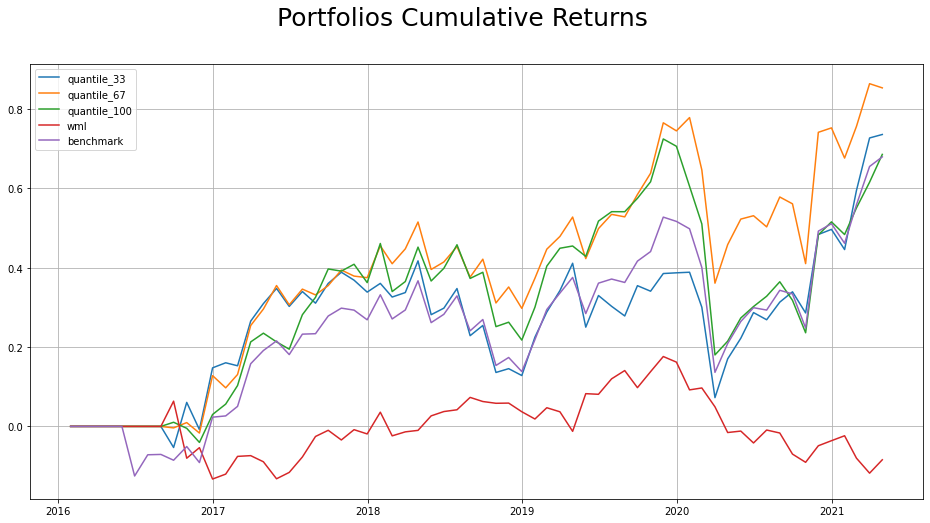

Momentum(looking_period=6, holding_period=6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.3  │          0.09 │          -0.17 │  0.12 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.99 │          0.33 │          -0.55 │  0.3  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.43 │          0.69 │           0.51 │  0.17 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.65 │          1.07 │           0.81 │  0.16 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.43 │         -0.01 │          -0.27 │ -0.92 │
├────────────────┼───────────────┼─────────

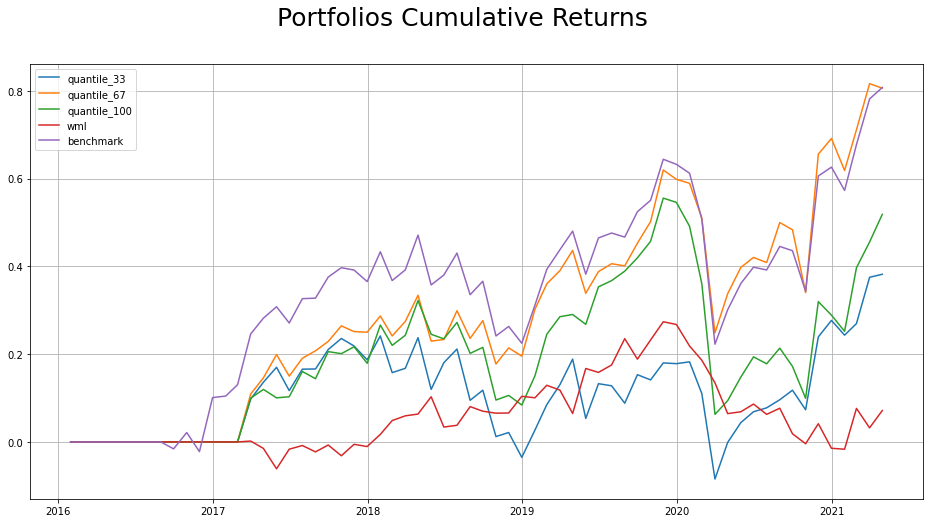

Momentum(looking_period=9, holding_period=9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.1  │         -0.35 │          -0.59 │  -0.5  │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -0.28 │         -1.13 │          -1.68 │  -1.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.54 │          0.4  │           0.25 │  -0.38 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.78 │          0.6  │           0.4  │  -0.39 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.32 │         -0.51 │          -0.71 │  -1.49 │
├────────────────┼─────────────

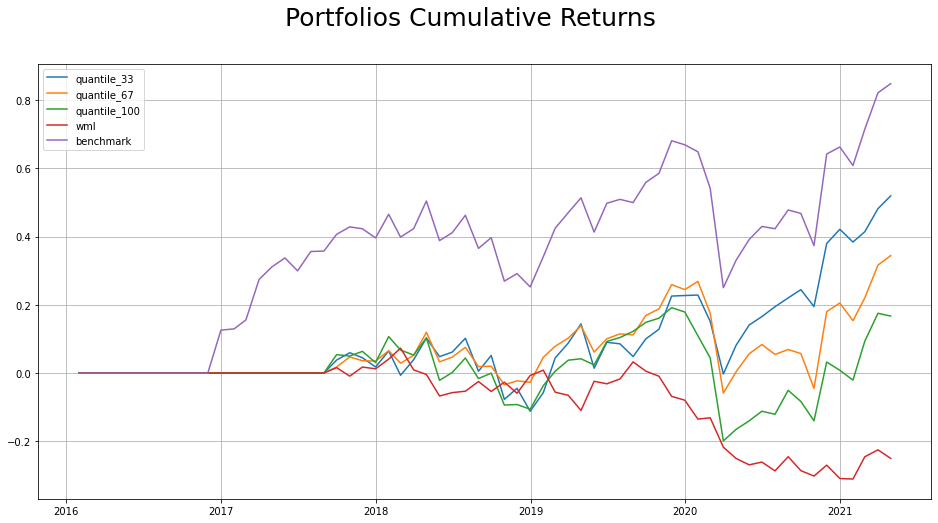

Momentum(looking_period=12, holding_period=12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.22 │         -0.3  │          -0.22 │  0    │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.77 │         -1.31 │          -0.72 │  0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.39 │          0.3  │           0.38 │ -0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.6  │          0.39 │           0.59 │ -0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.27 │         -0.48 │          -0.28 │ -0.88 │
├────────────────┼───────────────┼───────

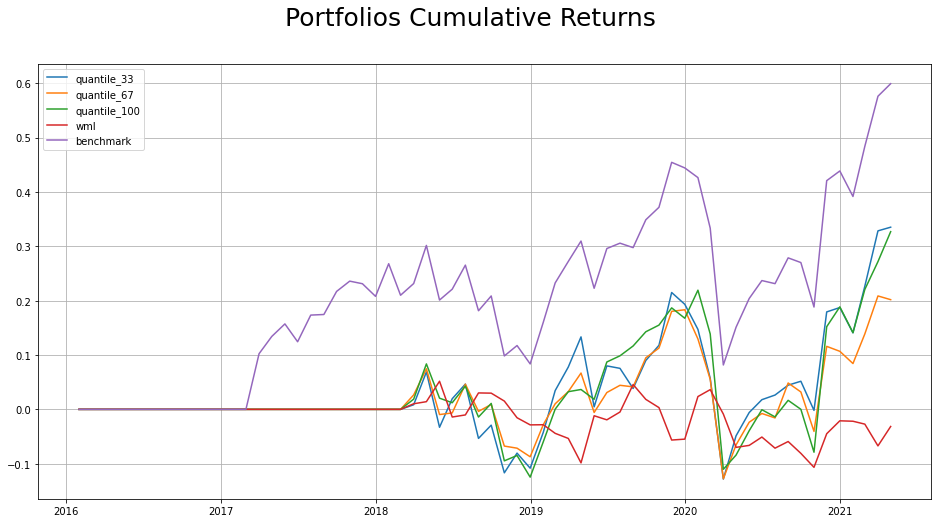

In [7]:
full_test_factor('Momentum', momentum, static=False, bigger_better=True)

Явно видно, что моментум-фактор не очень удачно подходит для портфельного инвестирования на рынке Италии. С ростом периода наблюдения все 3 портфеля начинают сильно отставать от индекса, при этом все 3 портфеля двигаются довольно похожим образом. WML-портфель имеет околонулевой или отрицательный коэффициент Шарпа (в зависимости от периода наблдения и периода удержания), поэтому можно утверждать, что данный фактор на рынке Италии не работает.

### Фактор стоимости

Value(looking_period=3, holding_period=3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.05 │         -0.04 │           0.84 │  -0.89 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -0.13 │         -0.13 │           2.96 │  -1.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.52 │          0.52 │           1.12 │  -0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          1.03 │          0.81 │           1.61 │  -0.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │          0.06 │         -0.17 │           0.64 │  -1.56 │
├────────────────┼───────────────┼

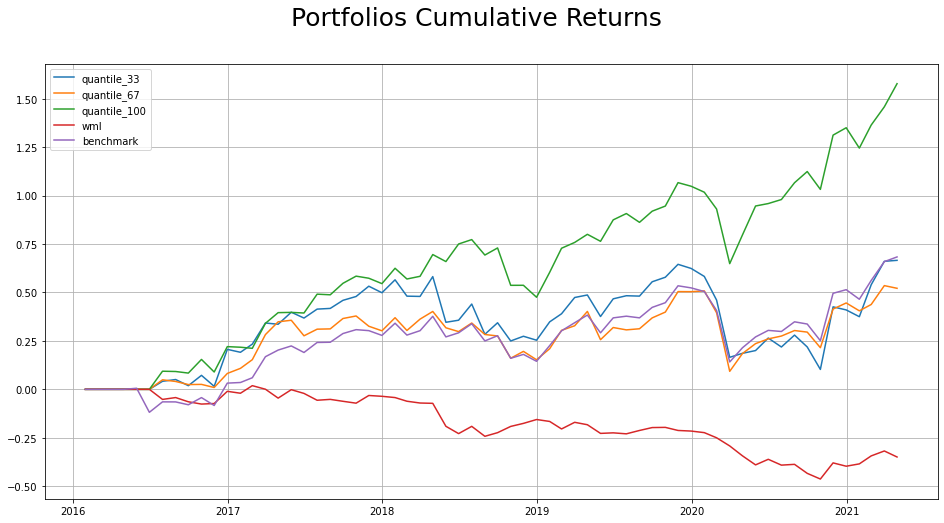

Value(looking_period=6, holding_period=6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.31 │         -0.18 │           0.49 │  -0.8  │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.15 │         -0.85 │           2.3  │  -1.84 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.49 │          0.55 │           1    │  -0.41 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.96 │          0.87 │           1.41 │  -0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.12 │         -0.2  │           0.33 │  -1.53 │
├────────────────┼───────────────┼

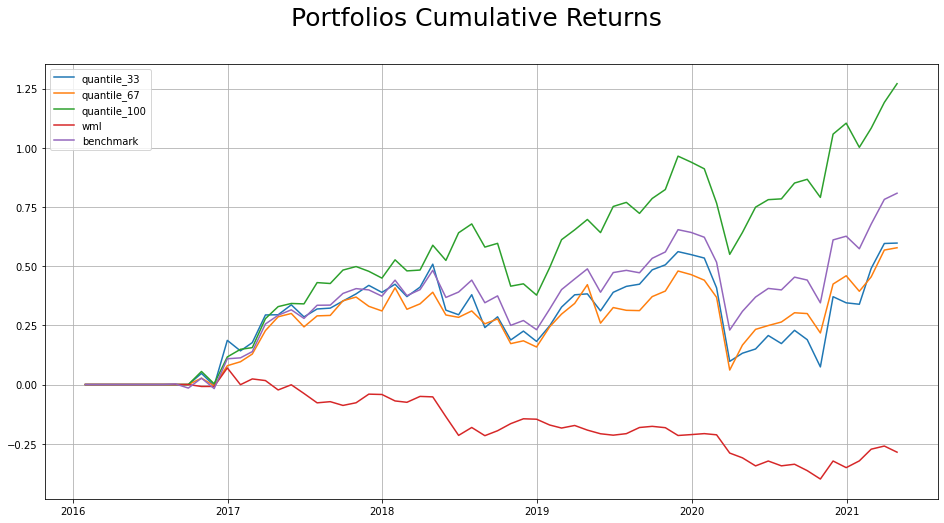

Value(looking_period=9, holding_period=9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.45 │         -0.14 │           0.37 │  -0.82 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.28 │         -0.47 │           1.22 │  -1.77 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.35 │          0.52 │           0.85 │  -0.52 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.62 │          0.79 │           1.19 │  -0.57 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.42 │         -0.24 │           0.16 │  -1.61 │
├────────────────┼───────────────┼

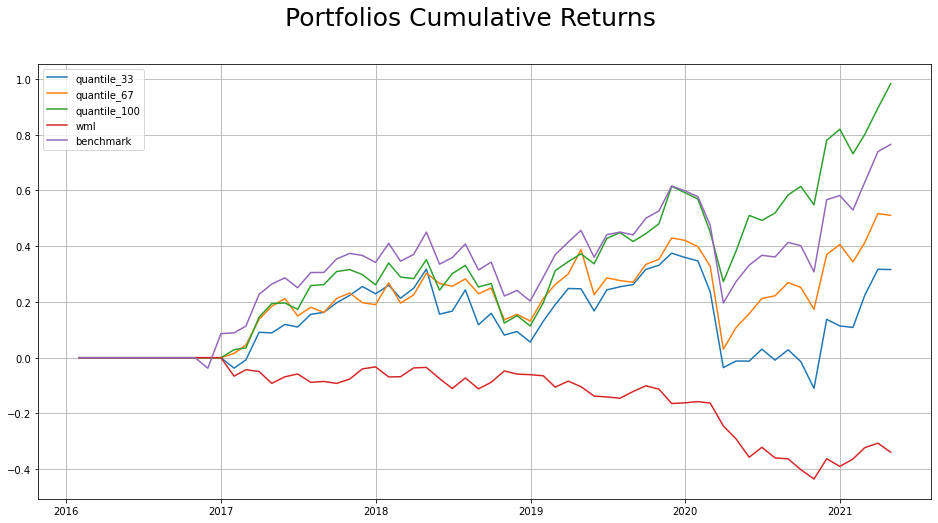

Value(looking_period=12, holding_period=12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.56 │         -0.33 │           0.41 │  -0.97 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -2    │         -1.42 │           1.56 │  -2.34 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.21 │          0.34 │           0.83 │  -0.75 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.37 │          0.51 │           1.12 │  -0.76 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.5  │         -0.35 │           0.26 │  -1.63 │
├────────────────┼──────────────

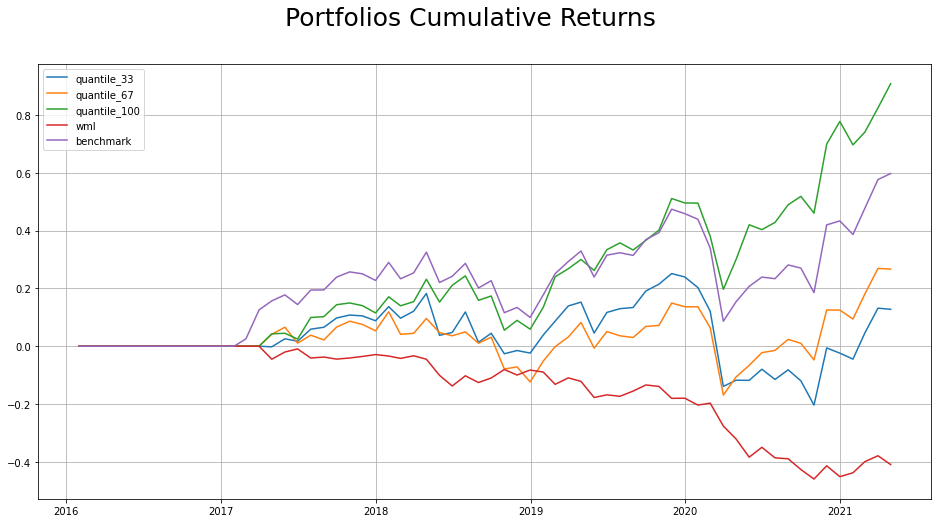

In [8]:
full_test_factor('Value', value, static=True, bigger_better=False)

Относительно фактора стоимости в классическом варианте (чем ниже `EV/EBITDA`, тем более недооценена компания) наблюдается довольно интересная картина: для всех периодов наблюдения и периодов удержания видно, что данный фактор работает с точностью до наоборот. Портфель из наиболее "дорогих" компаний показывает в среднем более высокий рост, чем индекс, в то время как портфель из наиболее "дешевых" компании оказывается худшим. Попробуем перевернуть торговую стратегию.

Value(looking_period=3, holding_period=3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.05 │         -0.04 │           0.84 │  0.89 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.13 │         -0.13 │           2.96 │  1.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.52 │          0.52 │           1.12 │  0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.03 │          0.81 │           1.61 │  0.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.06 │         -0.17 │           0.64 │ -0.4  │
├────────────────┼───────────────┼────────────

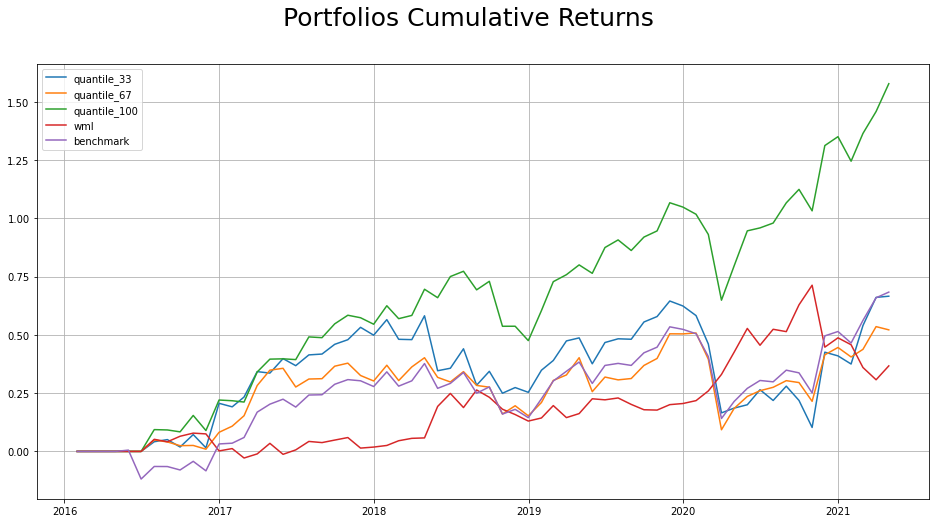

Value(looking_period=6, holding_period=6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.31 │         -0.18 │           0.49 │  0.8  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.15 │         -0.85 │           2.3  │  1.84 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.49 │          0.55 │           1    │  0.41 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.96 │          0.87 │           1.41 │  0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.12 │         -0.2  │           0.33 │ -0.62 │
├────────────────┼───────────────┼────────────

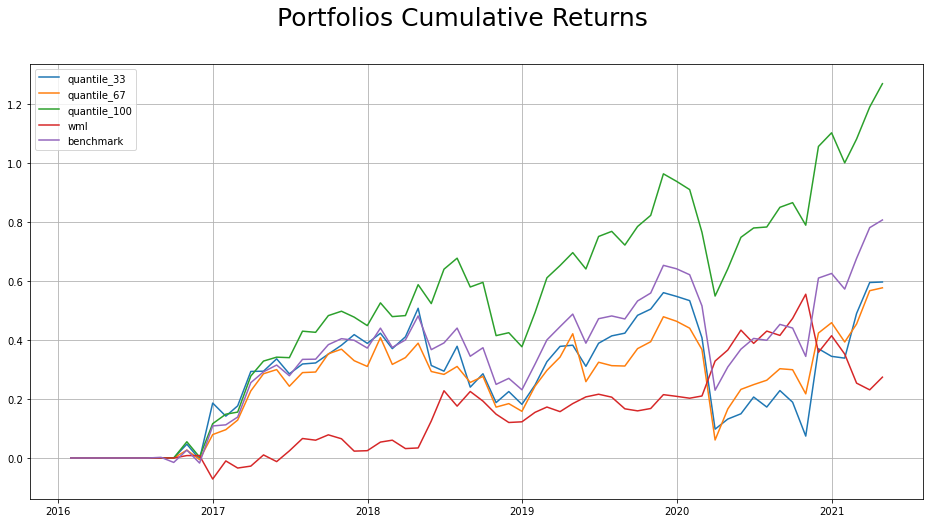

Value(looking_period=9, holding_period=9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.45 │         -0.14 │           0.37 │  0.82 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.28 │         -0.47 │           1.22 │  1.77 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.35 │          0.52 │           0.85 │  0.52 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.62 │          0.79 │           1.19 │  0.57 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.42 │         -0.24 │           0.16 │ -0.46 │
├────────────────┼───────────────┼────────────

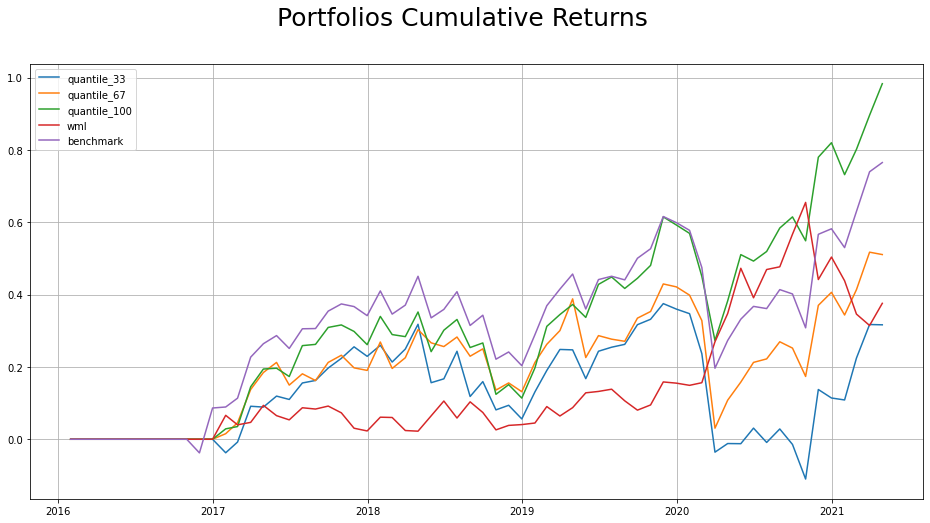

Value(looking_period=12, holding_period=12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.56 │         -0.33 │           0.41 │  0.97 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -2    │         -1.42 │           1.56 │  2.34 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.21 │          0.34 │           0.83 │  0.75 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.37 │          0.51 │           1.12 │  0.76 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.5  │         -0.35 │           0.26 │ -0.11 │
├────────────────┼───────────────┼──────────

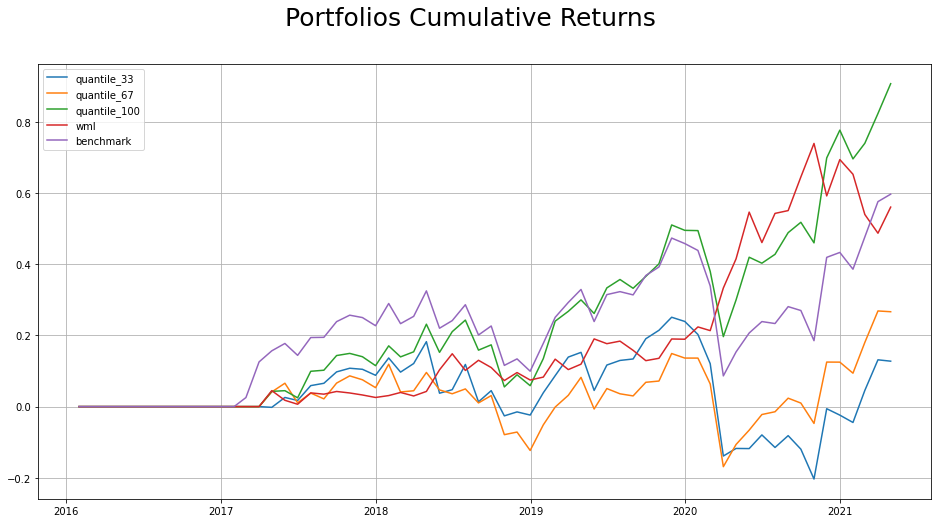

In [9]:
full_test_factor('Value', value, static=True, bigger_better=True)

Теперь уже WML-портфель показывает устойчивую положительную динамику, причем с увеличением периодов наблюдения и удержания ситуация улучшается. Стоит также заметить, что WML-портфель имеет отрицательную корреляцию с индексом. Таким образом, фактор стоимости на фондовом рынке Италии скорее всего имеет место быть, однако в перевернутом варианте.

### Фактор качества

Quality(looking_period=3, holding_period=3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.03 │         -0.03 │           0.8  │  0.77 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.07 │         -0.11 │           2.6  │  1.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.44 │          0.41 │           1.02 │  0.15 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.02 │          0.69 │           1.28 │  0.26 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.23 │         -0.1  │           0.49 │ -0.53 │
├────────────────┼───────────────┼──────────

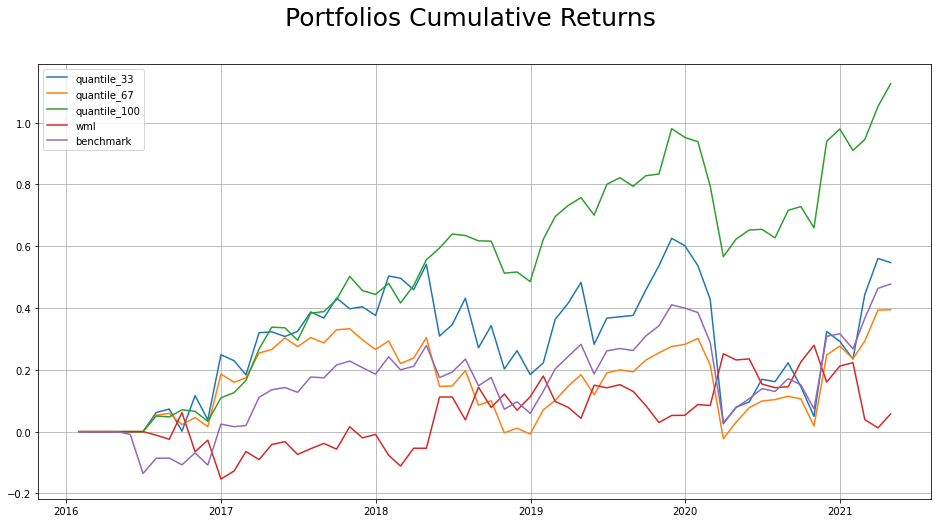

Quality(looking_period=6, holding_period=6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.24 │         -0.3  │           0.45 │  0.69 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.71 │         -1.45 │           1.59 │  1.2  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.43 │          0.34 │           0.82 │  0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.01 │          0.55 │           1.12 │  0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.1  │         -0.37 │           0.2  │ -0.81 │
├────────────────┼───────────────┼──────────

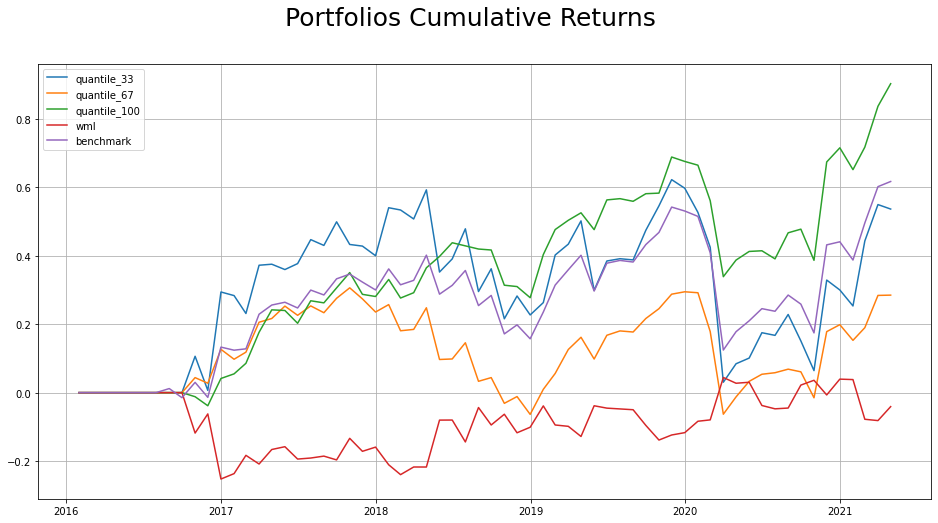

Quality(looking_period=9, holding_period=9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.47 │         -0.27 │           0.38 │  0.86 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.09 │         -0.88 │           1.23 │  1.61 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.23 │          0.29 │           0.73 │  0.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.5  │          0.46 │           0.96 │  0.47 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.35 │         -0.39 │           0.12 │ -0.37 │
├────────────────┼───────────────┼──────────

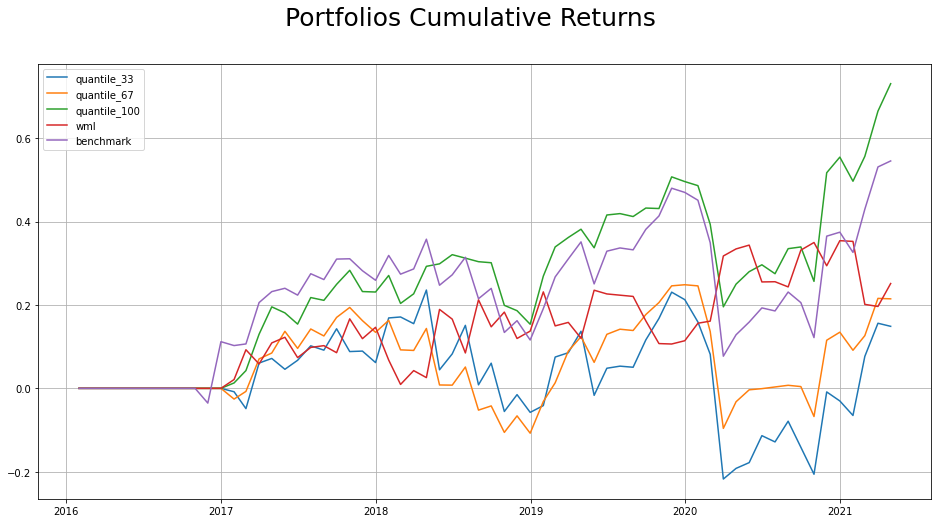

Quality(looking_period=12, holding_period=12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.48 │         -0.41 │           0.33 │  0.81 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.31 │         -1.55 │           1.07 │  1.44 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.18 │          0.17 │           0.63 │  0.29 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.37 │          0.29 │           0.81 │  0.44 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.31 │         -0.39 │           0.12 │ -0.24 │
├────────────────┼───────────────┼────────

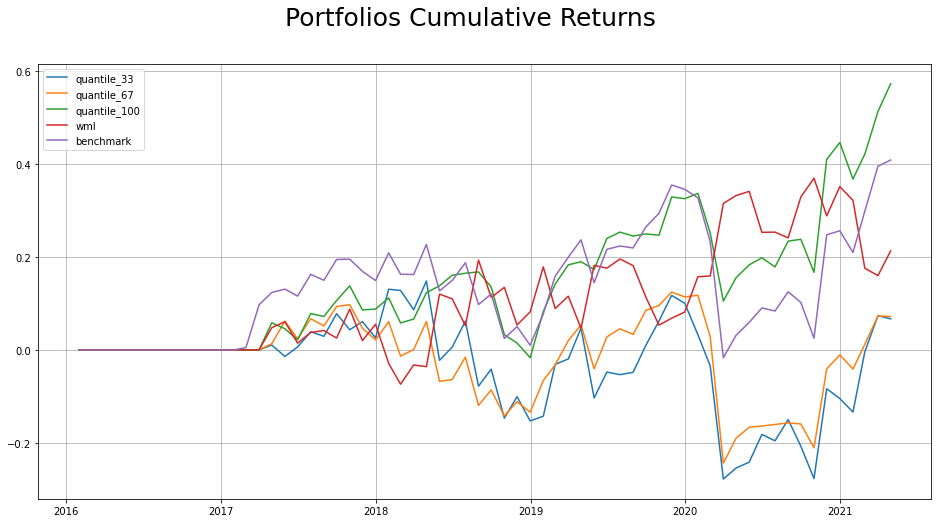

In [10]:
full_test_factor('Quality', quality, static=True, bigger_better=True)

Фактор качества на рынке Италии тоже проявляется особым образом: "winners" действительно показывают хорошую динамику лучше индекса, однако "losers" демонстрируют не настолько плохую динамику. Однако можно заметить, что с ростом периода наблюдения и периода удержания портфель из лучших компаний приближается к индексу, а портфель из худших отдаляется от него. Исходя из данной динамики, можно сделать предположение, что компании с высоким `ROA` в долгосрочном периоде включают в индекс, а компании с низким `ROA` - исключают.

### Фактор низкой волатильности

Low Volatility(looking_period=3, holding_period=3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.6  │          0.32 │          -0.19 │  0.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.95 │          1.17 │          -0.44 │  1.32 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.97 │          0.74 │           0.45 │  0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.2  │          1.15 │           1.03 │  0.17 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.24 │          0.19 │           0.07 │ -0.78 │
├────────────────┼───────────────┼───

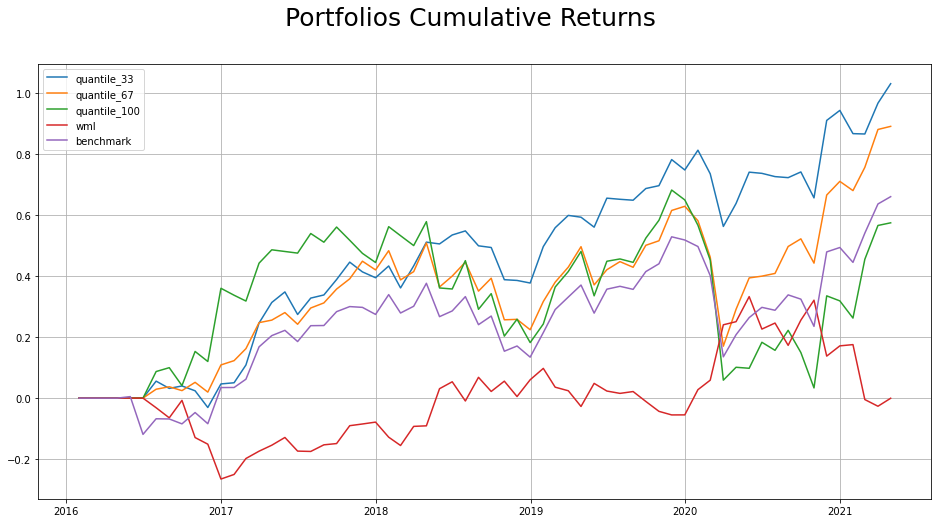

Low Volatility(looking_period=6, holding_period=6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.36 │          0.15 │          -0.49 │  0.85 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.4  │          0.91 │          -1.44 │  1.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.88 │          0.75 │           0.42 │  0.11 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.13 │          1.1  │           0.95 │  0.18 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.08 │          0.04 │          -0.1  │ -0.88 │
├────────────────┼───────────────┼───

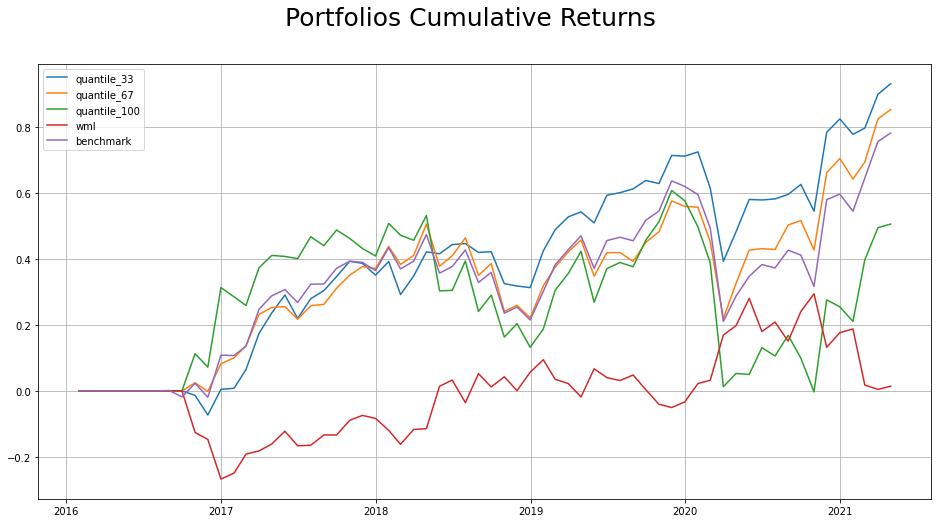

Low Volatility(looking_period=9, holding_period=9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.29 │          0.34 │          -0.8  │  1.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.02 │          1.31 │          -1.93 │  2.04 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.78 │          0.82 │           0.19 │  0.38 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.96 │          1.17 │           0.4  │  0.56 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.04 │          0.17 │          -0.6  │ -0.44 │
├────────────────┼───────────────┼───

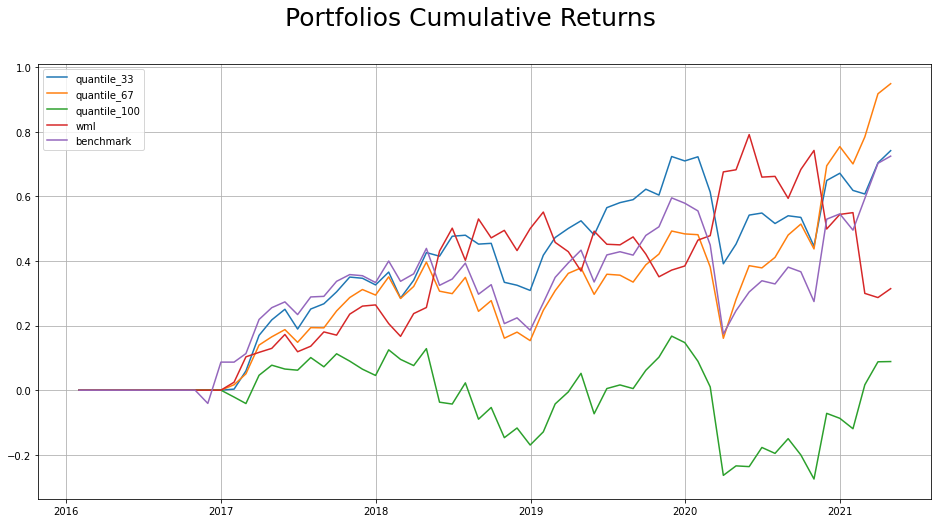

Low Volatility(looking_period=12, holding_period=12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.29 │         -0.15 │          -0.65 │  0.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.2  │         -0.58 │          -1.9  │  2.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.76 │          0.43 │           0.21 │  0.38 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.9  │          0.63 │           0.41 │  0.49 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.04 │         -0.23 │          -0.45 │ -0.37 │
├────────────────┼───────────────┼─

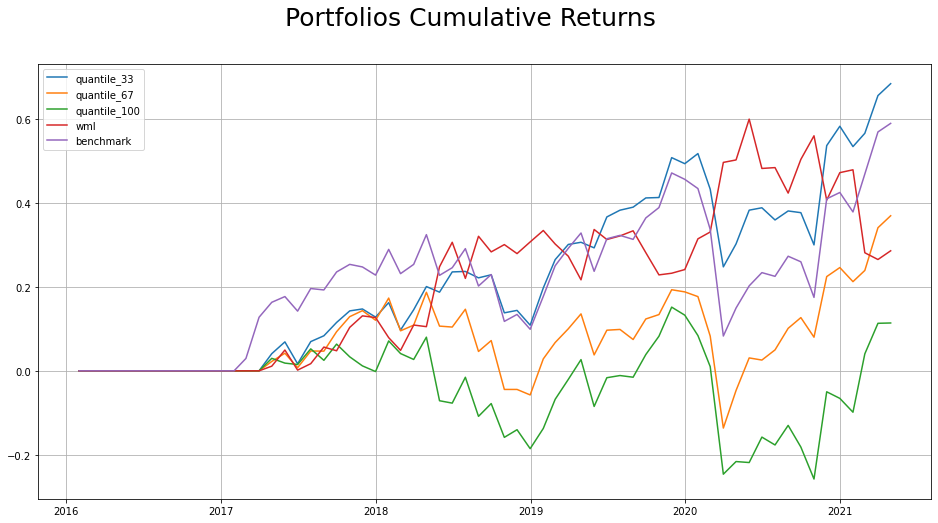

In [11]:
full_test_factor('Low Volatility', low_volatility, static=True, bigger_better=False)

Фактор низкой волатильности начинает проявлять себя при увеличении периодов наблюдения и удержания: с ростом данных параметром компании, имеющие наибольшее значение $\beta$-коэффициента, начинают сильнее отставать от индекса, в то время как компании с наибольшим значением $\beta$-коэффициента, наоборот, приближаются к индексу, из-за чего динамика WML-портфеля похожа на динамику WML-портфеля для фактора качества, однако имеет больший коэффициент Шарпа.

### Фактор размера

Size(looking_period=3, holding_period=3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.57 │          0.23 │          -0.05 │  0.61 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          2.06 │          0.96 │          -0.19 │  2.08 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.87 │          0.71 │           0.53 │  1.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.59 │          1.05 │           0.8  │  0.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.62 │          0.08 │          -0.18 │ -0.18 │
├────────────────┼───────────────┼─────────────

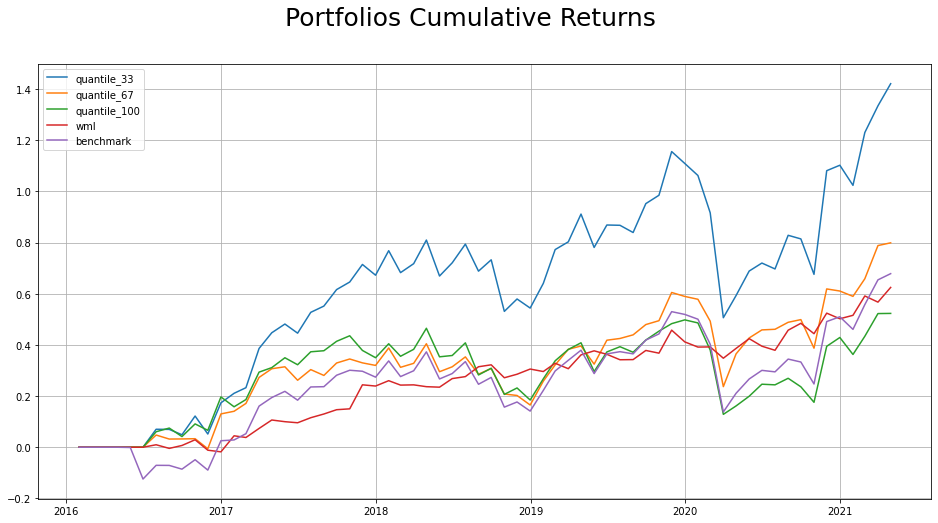

Size(looking_period=6, holding_period=6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.42 │         -0.11 │          -0.3  │  0.72 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          2.66 │         -0.64 │          -1.68 │  2.59 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.91 │          0.59 │           0.48 │  1.32 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.61 │          0.84 │           0.76 │  0.85 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.54 │         -0.23 │          -0.31 │ -0.22 │
├────────────────┼───────────────┼─────────────

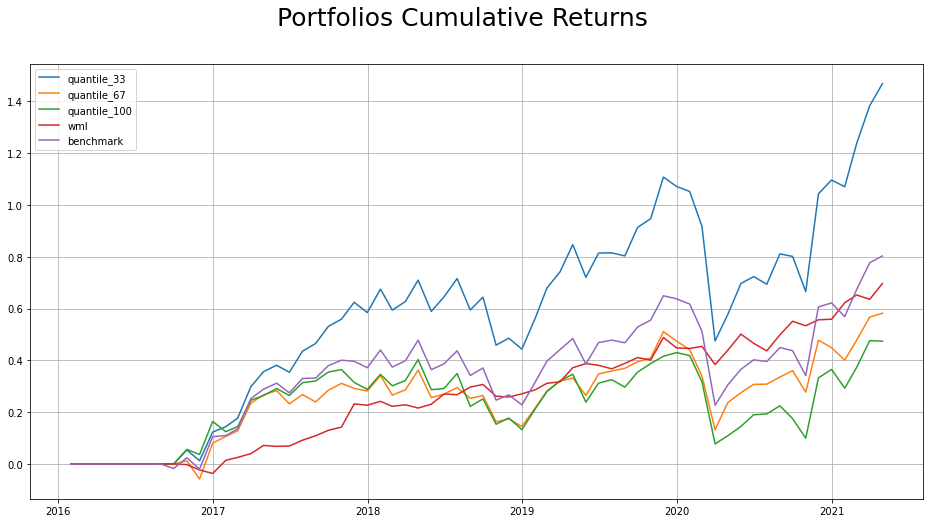

Size(looking_period=9, holding_period=9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.19 │         -0.05 │          -0.36 │  0.54 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.66 │         -0.21 │          -1.34 │  1.88 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.73 │          0.57 │           0.37 │  1    │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.24 │          0.77 │           0.56 │  0.68 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.21 │         -0.26 │          -0.47 │ -0.35 │
├────────────────┼───────────────┼─────────────

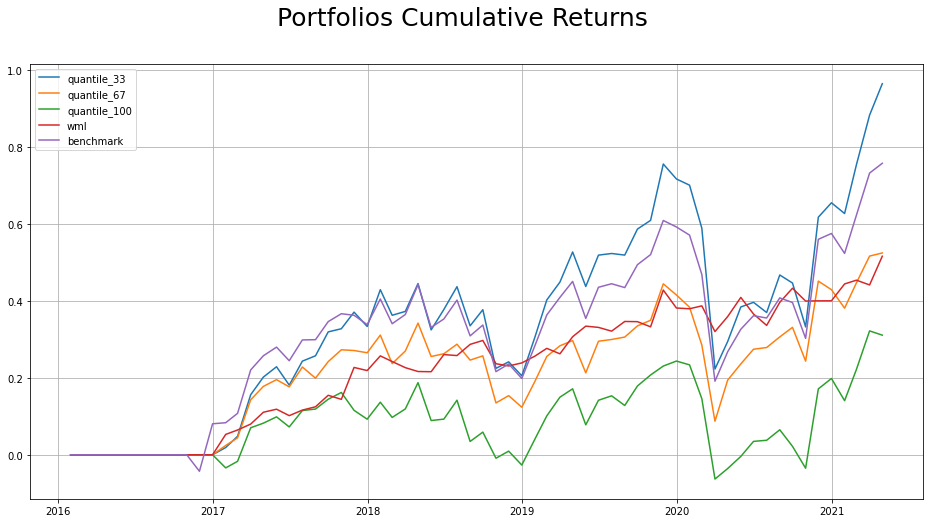

Size(looking_period=12, holding_period=12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.09 │         -0.16 │          -0.41 │  0.5  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.38 │         -0.76 │          -1.79 │  1.78 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.61 │          0.43 │           0.28 │  0.89 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.99 │          0.57 │           0.42 │  0.57 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.12 │         -0.29 │          -0.44 │ -0.3  │
├────────────────┼───────────────┼───────────

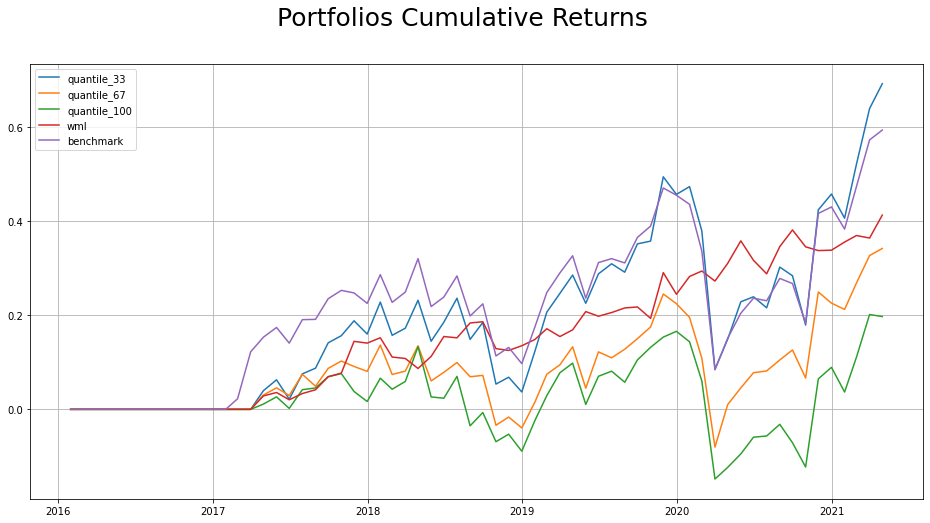

In [12]:
full_test_factor('Size', size, static=True, bigger_better=False)

Исходя из графиков кумулятивной доходности портфелей можно сделать практически такие же выводы, как для факторов качества и низкой волатильности: опять "лучшие" компании согласно фактору показывают лучшую динамику при маленьких значениях периодов наблюдения и удержания, а с их ростом приближаются к индексу, в то время как "худшие" - изначально близки к индексу, а с ростом параметров сильнее отдаляются от него.

Таким образом, можно сделать вывод, что моментум-фактор скорее отсуствует на итальянском фондовом рынке, портфели, основанные на факторах качества, низкой волатильности и размера, имеют очень похожее поведение, а фактор стоимости вообще удивляет - он достаточно эффективно работает, но в перевернутом варианте.

# Тестирование наиболее успешных факторных моделей с учетом фильтра ликвидности

Отбор лучших параметров для каждого фактора произведем на основе коэффициента Шарпа (без учета WML-портфелей, т.к. на практике маловероятно, что такой портфель удастся реализовать): 
* Перевернутый фактор стоимости: looking_period = 3, holding_period = 3, long-only (quantile_100) - `SR = 1.12`
* Фактор качества: looking_period = 3, holding_period = 3, long-only (quantile_100) - `SR = 1.02`
* Фактор низкой волатильности: looking_period = 3, holding_period = 3, long-only (quantile_33) - `SR = 0.97`
* Фактор размера: looking_period = 6, holding_period = 6, long-only (quantile_33) - `SR = 0.91`

В качестве фильтра ликвидности возьмем среднемесячный объем торгов внутри 1 торгового дня, который рассчитывается как $Avg.Trad.Volume_{daily} = \frac{Tot.Volume_{monthly} \cdot Close_{monthly}}{N}$, где $N$ - число дней в месяце. 

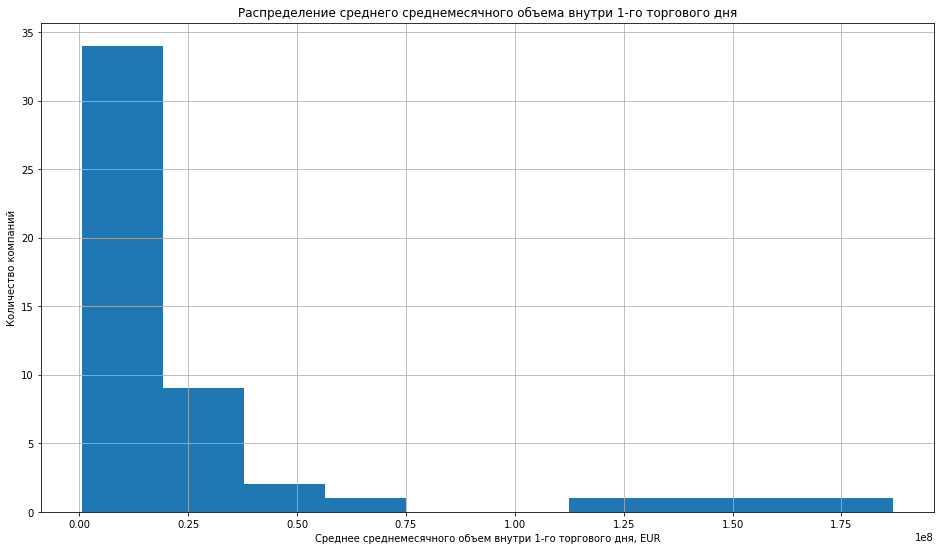

In [13]:
trading_volume.mean().hist()
plt.title('Распределение среднего среднемесячного объема внутри 1-го торгового дня')
plt.xlabel('Среднее среднемесячного объем внутри 1-го торгового дня, EUR')
plt.ylabel('Количество компаний')
plt.show()

По графику распределения среднего среднемесячного объема торгов внутри 1-го дня видно, что большая часть итальянских компаний не обладает очень высокой ликвидность. Было решено взять границу первого бина как минимальное значение данного параметра, т.е. 2 500 000 EUR.

In [14]:
liquidity_threshold = 2_500_000

## Перевернутый фактор стоимости

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │         -0.11 │          0.19 │           0.93 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │         -0.29 │          0.61 │           3.27 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.37 │          0.54 │           1.06 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          0.77 │          0.83 │           1.54 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │         -0.02 │          0.04 │           0.76 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         39.22 │         54.6  │         145.92 │
├────────────────┼───────────────┼──────────────

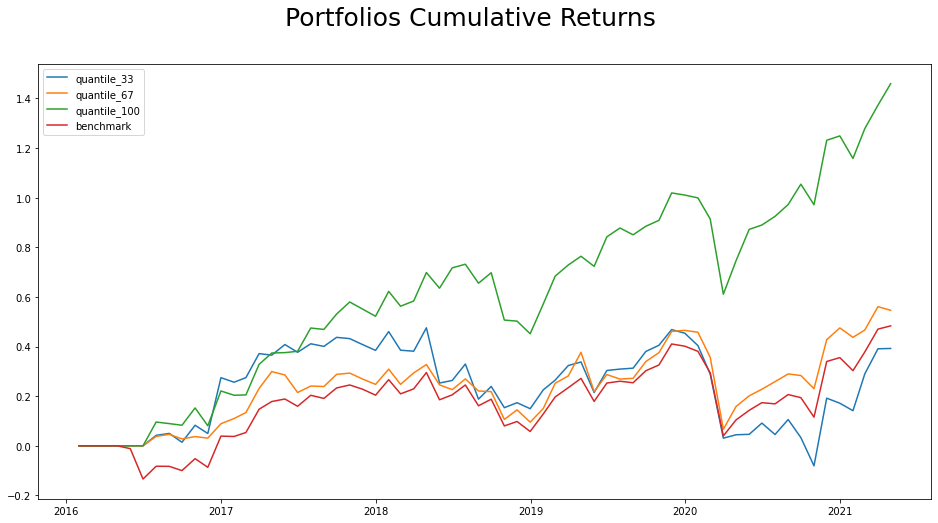

In [15]:
value_results = test_factor(value, static=True, 
                            looking=3, holding=3, 
                            filter_factor=trading_volume, min_threshold=liquidity_threshold)

## Фактор качества

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │          0.17 │          0.05 │           0.7  │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │          0.41 │          0.18 │           2.46 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.42 │          0.38 │           0.93 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          0.99 │          0.67 │           1.06 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │          0.33 │          0.01 │           0.4  │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         51.55 │         36.16 │          87.17 │
├────────────────┼───────────────┼──────────────

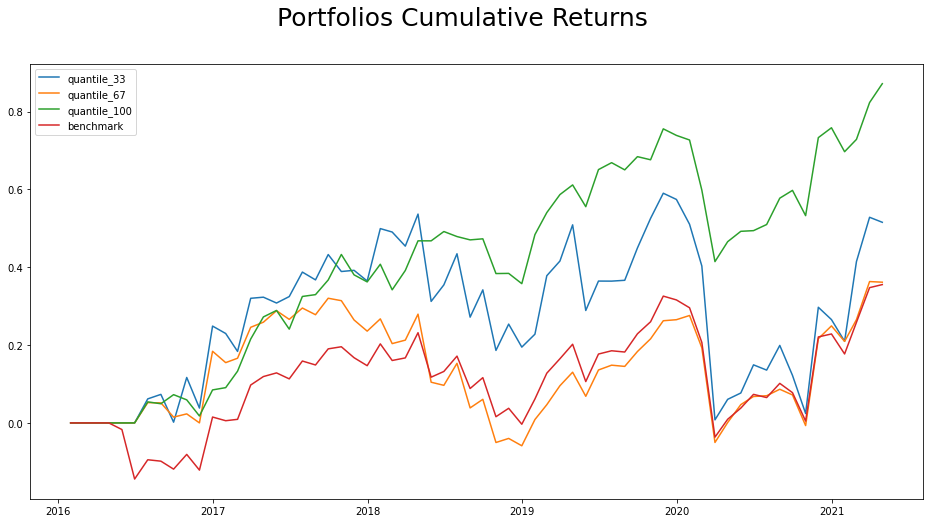

In [16]:
quality_results = test_factor(quality, static=True, 
                              looking=3, holding=3, 
                              filter_factor=trading_volume, min_threshold=liquidity_threshold)

## Фактор низкой волатильности

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │          0.59 │          0.29 │           0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │          1.91 │          1.1  │           0.24 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.86 │          0.6  │           0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          1.03 │          0.94 │           1.07 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │          0.28 │          0.18 │           0.32 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         82.78 │         65.35 │          60.16 │
├────────────────┼───────────────┼──────────────

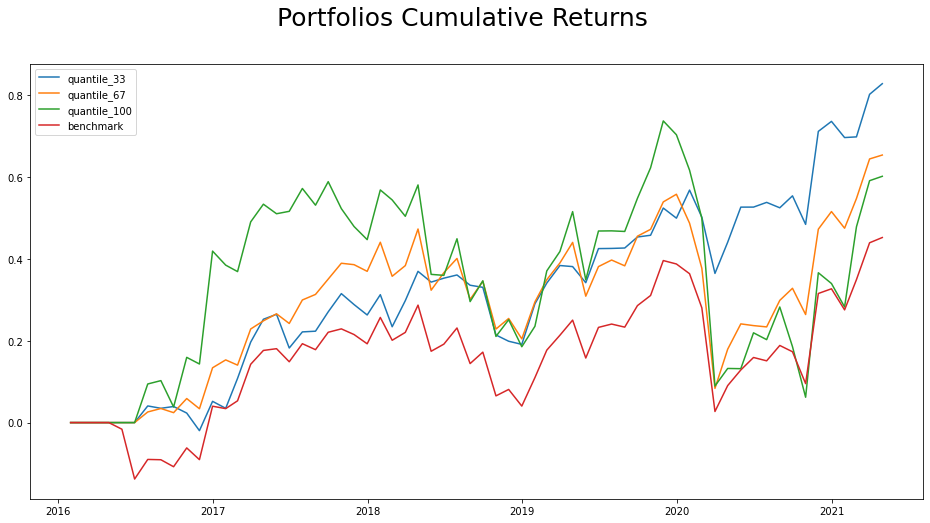

In [17]:
low_volatility_results = test_factor(low_volatility, static=True, 
                                     looking=3, holding=3, 
                                     filter_factor=trading_volume, min_threshold=liquidity_threshold)

## Фактор размера

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │          0.47 │          0.54 │           0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │          1.59 │          2.3  │           0.04 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.7  │          0.8  │           0.44 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          1.26 │          1.19 │           0.69 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │          0.48 │          0.41 │          -0.09 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         96.64 │         96.19 │          41.49 │
├────────────────┼───────────────┼──────────────

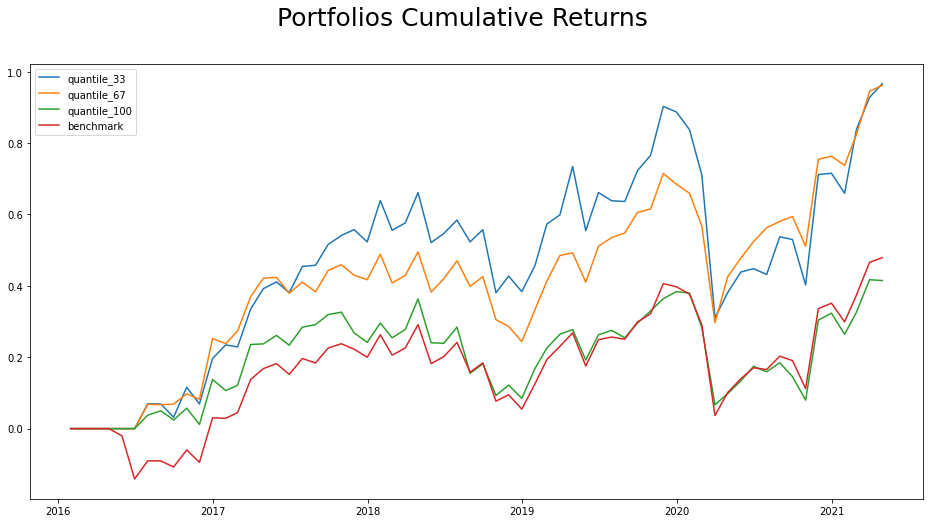

In [18]:
size_results = test_factor(size, static=True, 
                           looking=3, holding=3, 
                           filter_factor=trading_volume, min_threshold=liquidity_threshold)

Как видно из графиков и таблицы метрик качества работы стратегии, введение фильтра по ликвидности не очень сильно повлияло на показатели, но все-таки немного ухудшило их для всех стратегий. Хотя для фактора размера коэффициент Шарпа сильно упал, что неудивительно - маленькие компании обычно не имеют большого торгового оборота.

# Объединение наиболее успешных факторов в мультифакторную модель

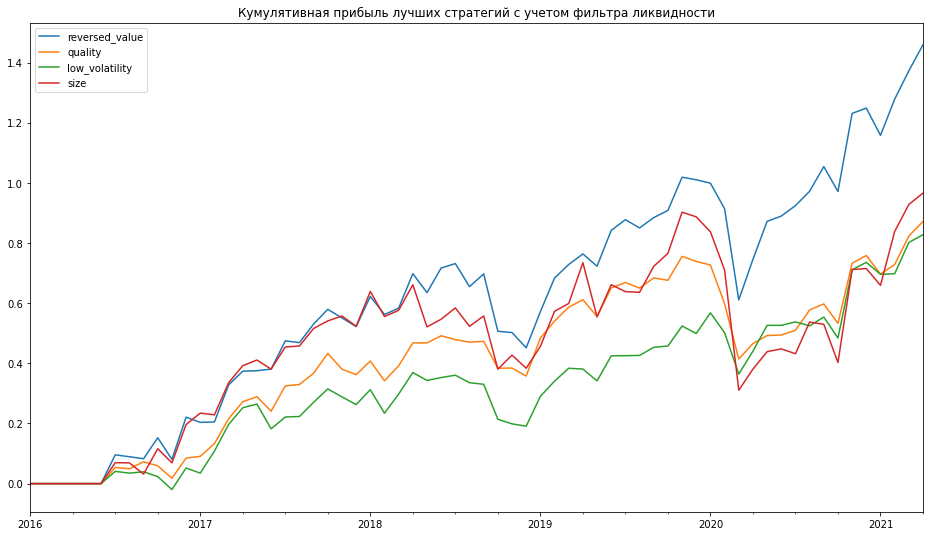

In [19]:
results = pd.DataFrame(
    {'reversed_value': value_results[6][-2],
     'quality': quality_results[6][-2],
     'low_volatility': low_volatility_results[6][0],
     'size': size_results[6][0]},
    index=prices.index
)

results.plot()
plt.title('Кумулятивная прибыль лучших стратегий с учетом фильтра ликвидности')
plt.show()

In [20]:
results.corr()

,reversed_value,quality,low_volatility,size
reversed_value,1.000000,0.970305,0.987055,0.902311
quality,0.970305,1.000000,0.944465,0.945990
low_volatility,0.987055,0.944465,1.000000,0.864648
size,0.902311,0.945990,0.864648,1.000000


Как видно из графиков и таблицы корреляций, предположение о том, что портвели на основе факторов качества и размера очень сильно скоррелированны. Портфель на основе перевернутого фактора стоимости также имеет высокую корреляцию с этими факторами. Наиболее "самостоятельным" портфелем оказался портфель на основе фактора низкой волатильности, поэтому его возьмем для конструирования окончательной торговой стратегии. Оставшиеся же 3 фактора будут использоваться для определения оптимальных весов портфеля, при этом из-за их высокой корреляции оставим только фактор размера как классический способ определения весов в портфеле. Однако использоваться он будет не в классическом варианте, т.к. нам необходимо, чтобы компании с меньшей капитализацией имели больший вес, поэтому возьмем для развесовки $\frac{1}{Market Cap}$. При использовании такой формулы чем больше капитализация компании, тем меньше ее вес, и наоборот.

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │          0.82 │          0.51 │           0.19 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │          2.42 │          1.69 │           0.38 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          1    │          0.73 │           0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          1.29 │          1.18 │           1.22 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │          0.53 │          0.42 │           0.46 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │        113.27 │         90.58 │          70.57 │
├────────────────┼───────────────┼──────────────

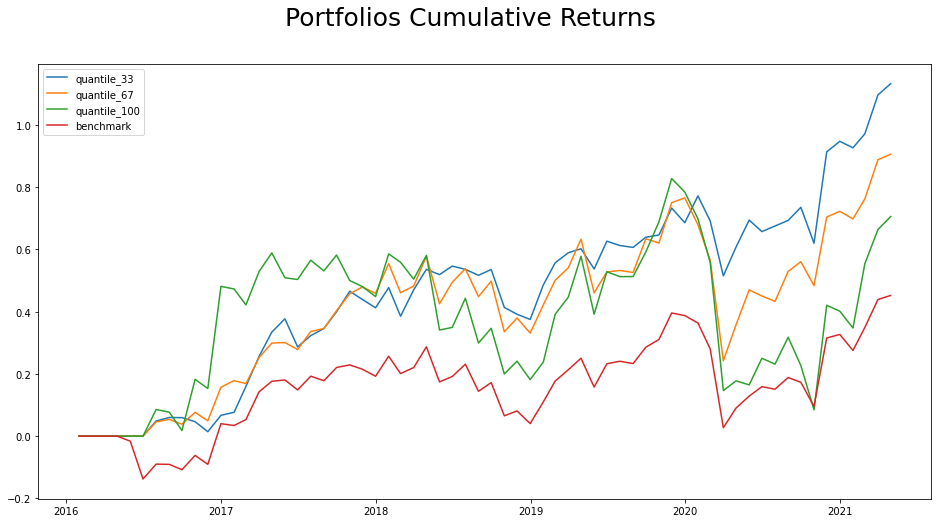

In [21]:
factor = get_factor(low_volatility, static=True, looking_period=3, lag=lag)
factor = set_stock_universe(factor, trading_volume, min_threshold=liquidity_threshold)

positions, names = get_all_quantiles(factor, quantile_step=quantile_step, 
                                     holding_period=3, static=True)
portfolio = set_value_weights(positions, 1 / size)
fee = get_fee_costs(portfolio, fee_rate=fee_rate)

universe_return = get_universe_return(prices)
portfolio_return = get_portfolio_return(portfolio, universe_return, fee_lists=fee)
benchmark_return = get_benchmark(prices, factor, universe_return, equal_weights=True)

result = compare_portfolios(names, portfolio_return, benchmark_return, prices.index)

С помощью такой комбинации факторов удалось улучшить коэффициент Шарпа (1 против 0.86), при этом общая прибыль возросла с 82.78% до 113.27%. Результат довольно-таки неплохой, но все-таки проверим его для большей уверенности:
$$
H_0: E(Excessive Returns) = 0 \; (\le0); \\
H_1: E(Excessive Retuns) > 0$$

In [22]:
from scipy.stats import norm

excessive_returns = result[6][0] - result[6][-1]
z_stat = (np.mean(excessive_returns) - 0) / (np.std(excessive_returns) / np.sqrt(np.size(excessive_returns)))
p_value = 1 - norm.cdf(z_stat)

print(f'p-value = {p_value:.2f}')

p-value = 0.00


Получившееся значение p-value равно 0, что дает основания утверждать, что при любом разумном уровне значимости гипотеза $H_0$ отвергается, значит получившаяся факторная инвестиционная стратегия неслучайным образом имеет избыточную доходность.